Dieses Skript dient zur automatisierten Extraktion und Analyse des Online-Forums Motor-Talk.de. Nachfolgend dient eine Zusammenfassung der gemachten Studie zum Überblick:

Aufgrund des wachsenden Marktanteils von Elektrofahrzeugen, wurde das Ziel gesetzt, automatisiert Online-Foren zu analysieren. Die Automatisierung soll so erarbeitet sein, dass diese bspw. jährlich durchgeführt werden kann und der Anwender so, die neusten Daten bereits analysiert erhaltet. Mit Hilfe der Zielsetzung und Automatisierung, kann auch das Problem welches bei Studien entsteht, gelöst werden. Die ressourcenaufwändigen Interviews bzw. Umfragen, würden somit entfallen. Aus diesem Grund wurde folgende Forschungsfrage gestellt: Wie können anhand von Q\&A Websites und auf der Basis von vordefinierten Leitfragen Anforderungen für Steckerfahrzeuge automatisiert erhoben und analysiert werden? Aus dieser Forschungsfrage heraus wurden vier Nebenforschungsfragen definiert.  
Um die Forschungsfrage zu beantworten, wurden die Textdaten aus den Online-Forum automatisch extrahiert und in Forumsfragen und Forumsantworten aufgeteilt. Im Anschluss wurden die Textdaten so aufbereitet, dass diese für die Erstellung der Keywörter verwendet werden können. Hierbei wurden die Stopp-Wörter entfernt, Bi- und Trigramme erstellt und die Textdaten lemmatisiert. Nach der Aufbereitung wurden die Keywörter mit Hilfe von Gensim LDA erstellt.\\
Die experimentelle Methodik hat aufgezeigt, dass eine automatisierte Analyse möglich ist. Die Leitfragen, welche erstellt wurden, konnten teilweise beantwortet werden. Konkret bedeutet dies, dass 6 von 15 Leitfragen beantwortet bzw. Antworten zugeordnet werden konnten. Eine Problematik besteht in der manuellen Erstellung der Keywörter für die Leitfragen. Stimmen diese nicht mit den Keywörter aus den Textdaten, kann es zu falschen Zuordnungen kommen. Jedoch könnte dies teilweise behoben werden, indem die Keywörter der Leitfragen noch um mehr Synonyme und passenden Wörtern zum Themengebiet erstellt werden.  
Die Arbeit hat aufgezeigt, dass eine automatisierte Analyse möglich ist. Die in dieser Arbeit durchgeführten Aufarbeitung zum Stand der Forschung, sowie der Methodik, können für weitere Forschung als Grundlage dienen. D.h. es können bspw. die Daten, welche extrahiert und analysiert wurden, weiterverwendet werden um als Trainingsmodell für Machine Learning oder präzisere Erstellung von Keywörter dienen.


Import der benötigten Python Bibliotheken

In [1]:
##Notwendige imports 
import nltk
import re
import requests
import gensim
import spacy
import itertools
import xlsxwriter
import pyLDAvis
import pyLDAvis.gensim
import logging
import warnings
import os


import pandas as pd
import numpy as np
import gensim.corpora as corpora
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as mcolors


from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from bs4 import BeautifulSoup
from collections import Counter
from pprint import pprint
from spacy import displacy
from spacy.matcher import PhraseMatcher
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("de_core_news_md")


logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
stop_words.extend(['ja', 'würde', 'wurde', 'erst', 'html', 'ganz', 'direkt', 'über', 'uber', 'demnächst', 'demnachst', 'brauchen', 'www', 'https', 'http', 'beim', 'eher', 'finden', 'bald', 'fur'])


#pfad zu mallet (Dieses muss angepasst werden)
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8'})
mallet_path = 'C:/mallet-2.0.8/bin/mallet.bat' # update this path




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jelen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jelen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Arbeitspfad (Muss angepasst werden)
path = 'C:/Users/jelen/Box/Master/Masterarbeit/Resultate/'

try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except NotADirectoryError:
    print("{0} is not a directory".format(path))
except PermissionError:
    print("You do not have permissions to change to {0}".format(path))

Current working directory: C:\Users\jelen\Box\Master\Masterarbeit\Resultate


Importieren der Leitfragen, Tokenizing und Clean Up

In [3]:
#Data Cleanup, Daten werden von Newline Characters
def data_cleanup(path_to_file):
    print("Start Datenbereinigung")
    #Excel to dataframe
    df = pd.read_excel(path_to_file, index_col=0)

    # Convert to list
    data = df.Text.tolist()

    # Remove new line characters
    data = [re.sub('\s+', ' ', str(sent)) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'"," ", sent) for sent in data]
    
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

    data_words = list(sent_to_words(data))
    
    return data_words, data
    print("Datenbereinigung abgeschlossen")


In [4]:
# Funktionsdefinition für die Entfernung der Stopp-Wörter, erstellung der bigrams, trigrams und Lemmatisierung
def remove_stopwords(texts):
    print("Stopwörter entfernen")
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    print("Bigramm erstellen")
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    print("Trigramm erstellen")
    #print(trigram_mod[bigram_mod[texts[0]]])
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    print("Start Lemmatization")
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
    print(texts_out[:1])
    print("Data lemmatized")


In [5]:
def create_dictionary_corpus(data_lemmatized):
    print("start dictionary corpus")
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    
    texts = data_lemmatized
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    print(corpus[:1])

    return id2word, corpus
    print("Corpus erstellt")

In [6]:
#Berechnung der Kohärenzwerte und Modelle für die einzelnen Topics 
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    print("start compute coherence values")
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
    print("values berechnet")

In [7]:
#Erstellung des Kohärenzdiagram
def create_coherence_plot(coherence_values, name, limit):
    # Show graph
    limit=40; start=2; step=2;
    x = range(start, limit, step)
    plt.figure(figsize=(18,12))
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend((["Kohärenz Score"]), loc='upper left')
    plt.grid()
    plt.savefig(name+'.png')
    plt.show()

    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    


In [8]:
#Erstellung des gewünschten Topics 
def format_topics_sentences(ldamodel, corpus, texts):
    print("start find topic senten")
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Erstellen von Exceldateien der Resultate

In [9]:
  
#Create Workbook Forumsfragen
url_workbook = xlsxwriter.Workbook('C:/Users/jelen/Box/Master/Masterarbeit/Resultate/URL.xlsx')




In [10]:
def write_workbook(path_to_workbook, dataframe):
    print("Write Result to Workbook")
    # Create a Pandas Excel writer using XlsxWriter as the engine.
    writer = pd.ExcelWriter(path_to_workbook, engine='xlsxwriter')

    # Convert the dataframe to an XlsxWriter Excel object.
    dataframe.to_excel(writer, sheet_name='Sheet1')

    # Get the xlsxwriter objects from the dataframe writer object.
    workbook  = writer.book
    worksheet = writer.sheets['Sheet1']
    workbook.close() 
    print("Result written")

In [11]:
#Such-URLs erstellen
def create_searchterm_url(url_workbook, leitfragen_workbook, url_base, url_restriction, url_year):
    print("Forenbeiträge suchen")
    workbook = xlsxwriter.Workbook(url_workbook)
    worksheet = workbook.add_worksheet('URLS')
    worksheet.write('B1', 'URL')
        
    df = pd.read_excel(leitfragen_workbook, index_col=0)
    keywords_str = df.Keywords.unique().tolist()
    row = 1
    
    for keywords in keywords_str:
        keywords = keywords.split(", ")
        for keyword in keywords:
            url_searchterm = '&se='+keyword+'+Elektrofahrzeug'
           
            for year in url_year:
                url = url_base+url_restriction+year+url_searchterm
                worksheet.write(row, 0, row)
                worksheet.write(row, 1, url)
                row += 1
    print(str(row)+" URLs erstellt")
    workbook.close()     
        

In [12]:
#Alle h2 Elemente suchen und extraktion von Titel und URL
def get_searchresult_urls(path_to_url_workbook, path_to_searchresult_workbook):
    print("Such-URLs erhalten")
    df = pd.read_excel(path_to_url_workbook, index_col=0)
    url_list = df.URL.tolist()
    workbook = xlsxwriter.Workbook(path_to_searchresult_workbook)
    worksheet = workbook.add_worksheet('URLS')
    worksheet.write('B1', 'URL')
    worksheet.write('C1', 'Result_URL')
    worksheet.write('D1', 'Forumtitel')

    row = 1
    for url in url_list:
        res = requests.get(url)
        html_page = res.content
        soup = BeautifulSoup(html_page, 'html.parser')      
        #find h2 tag
        find_all = soup.find_all('h2')
        data = soup.find_all('h2')
        nI = len(data)
                
        for i in range(1, nI-1):
            link_string = data[i].find_all('a')
            titel = link_string[0].get_text()
            url_result = link_string[0].get('href')
            
            worksheet.write(row, 0, row)
            worksheet.write(row, 1, url)
            worksheet.write(row, 2, url_result)
            worksheet.write(row, 3, titel)
            
            row += 1
        
    workbook.close()


In [13]:
#Extraktion der Forumfrage 
def get_forum_contributions(path_to_searchresult_workbook, path_to_forum_question_workbook):
    print("Fourumfragen extrahieren")
    df = pd.read_excel(path_to_searchresult_workbook, index_col=0)
    df = df.drop_duplicates(subset = ["Forumtitel"])
    df.head()
    workbook = xlsxwriter.Workbook(path_to_forum_question_workbook)
    worksheet = workbook.add_worksheet('URLS')
    worksheet.write('B1', 'URL')
    worksheet.write('C1', 'Forumtitel')
    worksheet.write('D1', 'Text')
    row_num = 1
    for index, row in df.iterrows():
        url = row['Result_URL']
        url = re.sub('\&highlight=', '', url)
        res = requests.get(url)
        url = res.url
        html_page = res.content
        soup = BeautifulSoup(html_page, 'html.parser')
        find_pages = soup.find_all("option")
        type(find_pages)
        forumcontent = "empty"
        if ( find_pages != []):
            post_id = url.split("#")
            text = soup.find_all("div", itemprop = "text")
            forumcontent = text[0].get_text()
            
            worksheet.write(row_num, 1, row["Result_URL"])
            worksheet.write(row_num, 2, row["Forumtitel"])
            worksheet.write(row_num, 3, forumcontent)
            row_num +=1
    workbook.close()


In [14]:
#Extraktion der Forumantworten
def get_forum_contributions_answers(path_to_searchresult_workbook, path_to_answer_workbook):
    #print("Forumantworten extrahieren")
    df = pd.read_excel(path_to_searchresult_workbook, index_col=0)
    df = df.drop_duplicates(subset = ["Forumtitel"])
    df.head()
    workbook = xlsxwriter.Workbook(path_to_answer_workbook)
    worksheet = workbook.add_worksheet('Forum_Antworten')
    worksheet.write('B1', 'URL')
    worksheet.write('C1', 'Forumtitel')
    worksheet.write('D1', 'Text')
    row_num = 1
    for index, row in df.iterrows():
        url = row['Result_URL']
        url = re.sub('\&highlight=', '', url)
        res = requests.get(url)
        url = res.url
        html_page = res.content
        
        soup = BeautifulSoup(html_page, 'html.parser')
        find_pages = soup.find_all("option")
        forumcontent = "empty"
        if ( find_pages != []):
            post_id = url.split("#")
            #print("post_id")
            #print(post_id)
            select = soup.find("select", id = "pagination-top")
            #list = soup.findAll('option')
            optionvalue = select.findChildren("option")
            i = int(optionvalue[-1]['value'])
            for x in range(i):
                try:
                    forumurl = url.split("?")
                    forumurl = post_id[0]+"?page="+str(x)
                    #print(forumurl)
                    res = requests.get(forumurl)
                    url = res.url
                    html_page = res.content
                    soup = BeautifulSoup(html_page, 'html.parser')
                    text = soup.find_all("div", itemprop = "text")
                    for x in range(1, len(text)):
                        forumcontent = text[x].get_text()
                   # print(forumcontent)
                        worksheet.write(row_num, 1, url)
                        worksheet.write(row_num, 2, row['Forumtitel'] )
                        worksheet.write(row_num, 3, forumcontent)
                        row_num +=1
                except:
                    print("Ein Fehler ist aufgetreten")
    workbook.close()

In [15]:
#Vergleich der Keywörter aus den Leitfragen mit Keywörter der Textdaten
def compare_dominant_topics(leitfragen_workbook, forum_topic_workbook):
    df1 = pd.read_excel(leitfragen_workbook, index_col=0)
    df2 = pd.read_excel(forum_topic_workbook, index_col=0)
    
    df1_topics = pd.DataFrame(df1,columns=['Dominant_Topic','Keywords'])
    df1_topics = df1_topics.drop_duplicates()
    
    for index, row in df1_topics.iterrows():
        keywords = row['Keywords'].split(", ")
        
        df2["Topic_Nummer"+str(row['Dominant_Topic'])] = df2['Keywords'].apply(lambda x: 1 if any(i in x for i in keywords) else 0)
        
        
    return df2

In [16]:
def create_graphs(data_lemmatized, optimal_model, num_topic, plot_name):
    
    topics = optimal_model.show_topics(formatted=False, num_topics=num_topic)
    data_flat = [w for w_list in data_lemmatized for w in w_list]
    counter = Counter(data_flat)
    out = []
    
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
    write_workbook(plot_name+'.xlsx', df)

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(int(num_topic/2), 2, figsize=(32,70), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[1], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[1], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[1])
        ax_twin.set_ylim(0, 0.5); ax.set_ylim(0, 5000)
        ax.set_title('Topic: ' + str(i), color=cols[1], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.savefig(plot_name+'.png')
    plt.show()



In [17]:
#Suchen der besten Fragen und Antworten
def find_most_representative_doc(df_topic, path_to_best_answer_workbook):
    #Group top 5 sentences under each topic
    sent_topics_sorteddf_mallet = pd.DataFrame()

    sent_topics_outdf_grpd = df_topic.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                                 grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                                axis=0)

    # Reset Index    
    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    # Format
    sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

    # Show
    sent_topics_sorteddf_mallet.to_excel(path_to_best_answer_workbook)  
    return sent_topics_sorteddf_mallet.head(30)

In [21]:
#Leitfragen beantworten
def merge_question_answer_leitfrage(path_to_best_answer, path_to_best_question, path_to_leitfragen, path_to_question_combined, path_to_answer_combined):
    df_best_answer = pd.read_excel(path_to_best_answer, index_col=0)
    df_best_question = pd.read_excel(path_to_best_question, index_col=0)
    df_leitfrage = pd.read_excel(path_to_leitfragen, index_col=0)
    df_question = pd.read_excel(path_to_question_combined, index_col=0)
    df_answer = pd.read_excel(path_to_answer_combined, index_col=0)       
    
    df1_topics = pd.DataFrame(df_leitfrage,columns=['Dominant_Topic','Keywords'])
    df1_topics = df1_topics.drop_duplicates()
    df_answer = df_answer.drop_duplicates()
    
    chart_leitfrage = []
    chart_answers = []
    chart_questions = []
    
    
    for index, row in df1_topics.iterrows():

        keywords = row['Keywords'].split(", ")
        
        df_best_answer["Topic_Nummer"+str(row['Dominant_Topic'])] = df_best_answer['Keywords'].apply(lambda x: 1 if any(i in x for i in keywords) else 0)
        df_best_question["Topic_Nummer"+str(row['Dominant_Topic'])] = df_best_question['Keywords'].apply(lambda x: 1 if any(i in x for i in keywords) else 0)
           
    count_row = df1_topics.shape[0]
    print(count_row)
    
    for x in range(0, count_row):
        workbook = xlsxwriter.Workbook('Resultate_Leitfragen/Leitfrage'+str(x)+'.xlsx')
        worksheet = workbook.add_worksheet('Leitfrage best QA')
        df = df_leitfrage.loc[df_leitfrage['Dominant_Topic'] == x]
        
        
        worksheet.write('A1', 'Leitfrage')
        worksheet.write('B1', df.iloc[0]['Text'])
        
        best_answers = df_best_answer.loc[df_best_answer['Topic_Nummer'+str(x)] == 1]
        count_best_answer_row = best_answers.shape[0]
        
        best_question = df_best_question.loc[df_best_question['Topic_Nummer'+str(x)] == 1]
        count_best_question_row = best_question.shape[0]
        question = df_question.loc[df_question['Topic_Nummer'+str(x)] == 1]
        count_question_row = question.shape[0]
        
        answer = df_answer.loc[df_answer['Topic_Nummer'+str(x)] == 1]
        count_answer_row = answer.shape[0]
        
        chart_leitfrage.append("Leitfrage"+str(x))
        chart_questions.append(count_question_row)
        chart_answers.append(count_answer_row)
        
        if count_best_answer_row > 0:
            #print('count_answer_row'+str(count_answer_row))
            for y in range(0, count_best_answer_row):
                worksheet.write('A'+str(y+2+count_best_question_row), "Beste Antwort")
                worksheet.write('C'+str(y+2+count_best_question_row), best_answers.iloc[y]['Text'])
                #print('Leitfrage'+str(x)+':'+str(y))
                #pprint(best_answers.iloc[y]['Text'])
                
                
        if count_best_question_row > 0:
            #print('count_question_row'+str(count_question_row))
            for z in range(0, count_best_question_row):
                worksheet.write('A'+str(z+2), "Beste Frage")
                worksheet.write('C'+str(z+2), best_question.iloc[z]['Text'])
                #print('Leitfrage'+str(x)+':'+str(z))
                #pprint(best_question.iloc[z]['Text'])
                
        if count_question_row > 0:
            #print('count_question_row'+str(count_question_row))
            question_sheet = workbook.add_worksheet('Fragen')
            question_sheet.write('A1', "Anzahl Fragen")
            question_sheet.write('B1', str(count_question_row))
            for a in range(0, count_question_row):
                question_sheet.write('A'+str(a+2), "Fragen")
                question_sheet.write('C'+str(a+2), question.iloc[a]['Text'])
                #print('Leitfrage'+str(x)+':'+str(z))
                #pprint(best_question.iloc[z]['Text'])
                
        if count_answer_row > 0:
            #print('count_question_row'+str(count_question_row))
            answer_sheet = workbook.add_worksheet('Antworten')
            answer_sheet.write('A1', "Anzahl Antworten")
            answer_sheet.write('B1', str(count_answer_row))
            for b in range(0, count_answer_row):
                answer_sheet.write('A'+str(b+2), "Anwort"+str(b))
                answer_sheet.write('C'+str(b+2), answer.iloc[b]['Text'])
                #print('Leitfrage'+str(x)+':'+str(z))
                #pprint(best_question.iloc[z]['Text'])        
            
            
        
        #pprint(df_best_answer.loc[df_best_answer['Topic_Nummer'+str(x)] == 1])

        workbook.close()
    plt.bar(chart_leitfrage,chart_answers)
    plt.show()

Rufe die erstellten Funktionen auf. Start des Programms

Start Datenbereinigung
Forenbeiträge suchen
259 URLs erstellt
Such-URLs erhalten
Fourumfragen extrahieren
Start Datenbereinigung
Stopwörter entfernen
Bigramm erstellen
Trigramm erstellen
Start Lemmatization
start dictionary corpus
[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]]
start compute coherence values


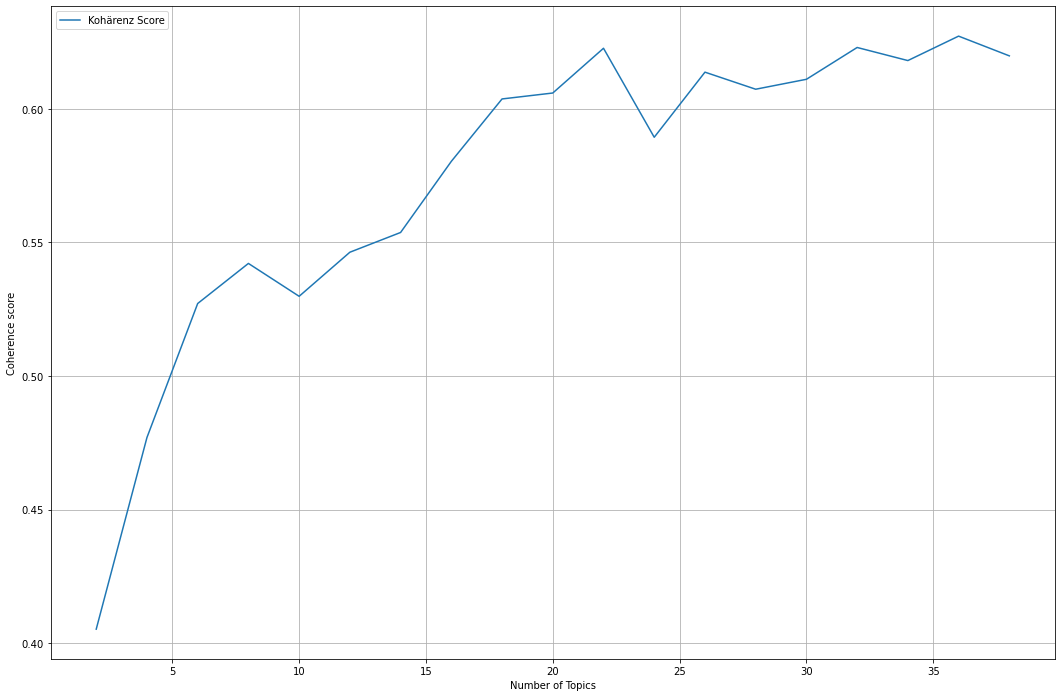

Num Topics = 2  has Coherence Value of 0.4053
Num Topics = 4  has Coherence Value of 0.477
Num Topics = 6  has Coherence Value of 0.5272
Num Topics = 8  has Coherence Value of 0.5422
Num Topics = 10  has Coherence Value of 0.5299
Num Topics = 12  has Coherence Value of 0.5464
Num Topics = 14  has Coherence Value of 0.5537
Num Topics = 16  has Coherence Value of 0.5804
Num Topics = 18  has Coherence Value of 0.6037
Num Topics = 20  has Coherence Value of 0.6059
Num Topics = 22  has Coherence Value of 0.6227
Num Topics = 24  has Coherence Value of 0.5894
Num Topics = 26  has Coherence Value of 0.6137
Num Topics = 28  has Coherence Value of 0.6073
Num Topics = 30  has Coherence Value of 0.6111
Num Topics = 32  has Coherence Value of 0.623
Num Topics = 34  has Coherence Value of 0.6181
Num Topics = 36  has Coherence Value of 0.6272
Num Topics = 38  has Coherence Value of 0.6198
Input number of topics


 22


Input Best Topiclist:


 10


start find topic senten
Write Result to Workbook
Result written


<ipython-input-16-f9f44ed0a0a4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-f9f44ed0a0a4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-f9f44ed0a0a4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-f9f44ed0a0a4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-f9f44ed0a0a4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation

Write Result to Workbook
Result written
Forumfragen bereinigt? (y/n)


 y


Start Datenbereinigung
Stopwörter entfernen
Bigramm erstellen
Trigramm erstellen
Start Lemmatization
start dictionary corpus
[[(0, 1), (1, 1), (2, 1), (3, 1)]]
start compute coherence values


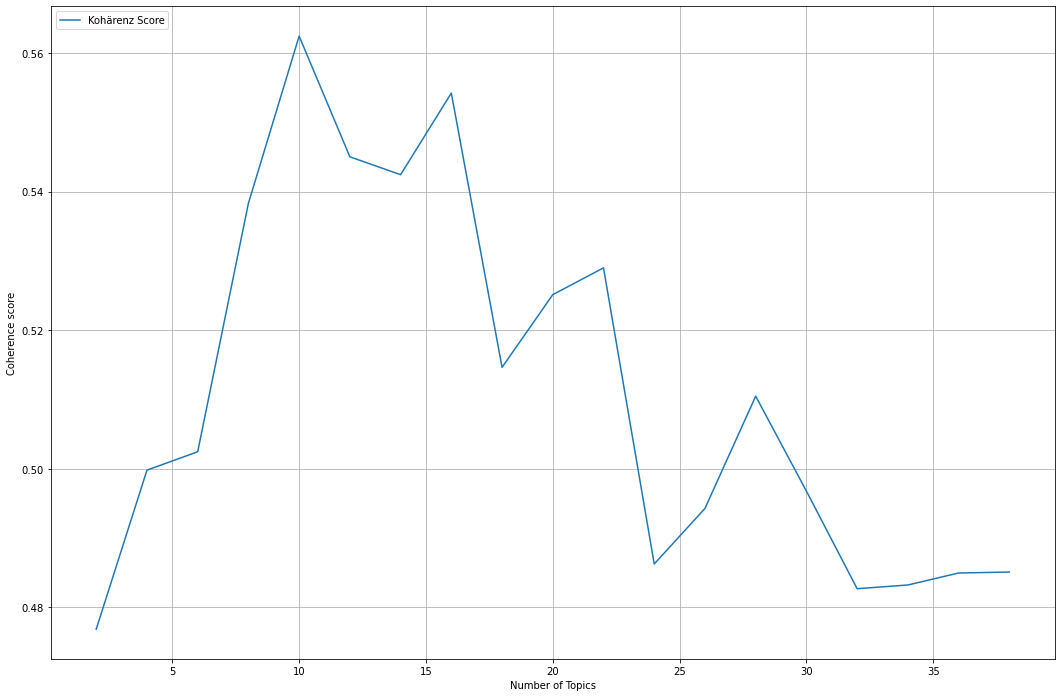

Num Topics = 2  has Coherence Value of 0.4769
Num Topics = 4  has Coherence Value of 0.4998
Num Topics = 6  has Coherence Value of 0.5025
Num Topics = 8  has Coherence Value of 0.5383
Num Topics = 10  has Coherence Value of 0.5624
Num Topics = 12  has Coherence Value of 0.545
Num Topics = 14  has Coherence Value of 0.5425
Num Topics = 16  has Coherence Value of 0.5542
Num Topics = 18  has Coherence Value of 0.5147
Num Topics = 20  has Coherence Value of 0.5251
Num Topics = 22  has Coherence Value of 0.529
Num Topics = 24  has Coherence Value of 0.4863
Num Topics = 26  has Coherence Value of 0.4943
Num Topics = 28  has Coherence Value of 0.5105
Num Topics = 30  has Coherence Value of 0.4968
Num Topics = 32  has Coherence Value of 0.4827
Num Topics = 34  has Coherence Value of 0.4832
Num Topics = 36  has Coherence Value of 0.485
Num Topics = 38  has Coherence Value of 0.4851
Input number of topics


 10


Input Best Topiclist:


 4


Write Result to Workbook
Result written


<ipython-input-16-f9f44ed0a0a4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-f9f44ed0a0a4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-f9f44ed0a0a4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-f9f44ed0a0a4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-16-f9f44ed0a0a4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation

start find topic senten
Write Result to Workbook
Result written
Write Result to Workbook
Result written
Write Result to Workbook
Result written
15


IndexError: single positional indexer is out-of-bounds

In [19]:
print## Build URL
url_base = 'https://www.motor-talk.de/suche.html?search'
url_restriction = '&bfm=452'
url_year = ['&yfm=2019', '&yfm=2020', '&yfm=2021']

#workbook path
url_workbook = 'URL.xlsx'
leitfragen_workbook = 'LeitfragenTopics_manuell.xlsx' 
path_to_searchresult_workbook = 'Forum_URL.xlsx'
path_to_forum_question_workbook = 'Forum_Frage.xlsx'
forumquestion_topic_workbook = 'Forum_FrageTopics.xlsx'
path_to_answer_workbook = 'Forum_Antworten.xlsx'
forumanswer_topic_workbook = 'Forum_AntwortenTopics.xlsx'

forumquestion_topic_workbook_compare = 'ForumfragenTopicsVonLeitfragen.xlsx'
forumanswer_topic_workbook_compare = 'Forum_AntwortenTopicsVonLeitfragen.xlsx'
leitfragen_workbook_manuell = '../Leitfragen/Leitfragen.xlsx'

#Leitfragen bereinigen und tokenizing
data_words_leitfragen = data_cleanup('../Leitfragen/Leitfragen.xlsx')

create_searchterm_url(url_workbook, leitfragen_workbook_manuell, url_base, url_restriction, url_year)
get_searchresult_urls(url_workbook, path_to_searchresult_workbook)
get_forum_contributions(path_to_searchresult_workbook, path_to_forum_question_workbook)
data_words_forumquestion = data_cleanup(path_to_forum_question_workbook)
   
bigram = gensim.models.Phrases(data_words_forumquestion[0], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words_forumquestion[0]], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

data_words_forumquestion_no_stop = remove_stopwords(data_words_forumquestion[0])

data_words_forumquestion_bigram = make_bigrams(data_words_forumquestion_no_stop)

data_words_forumquestion_trigram = make_trigrams(data_words_forumquestion_bigram)

data_words_forumquestion_lemmatized = lemmatization(data_words_forumquestion_bigram, allowed_postags=['NOUN', 'ADJ', 'VERB'])

corpus_forumquestion = create_dictionary_corpus(data_words_forumquestion_lemmatized)

coherence_values_list = compute_coherence_values(corpus_forumquestion[0], corpus_forumquestion[1], data_words_forumquestion_lemmatized, limit = 40, start=2, step=2)

create_coherence_plot(coherence_values_list[1], 'plot/coherenceFragen', limit=40,)
    
print("Input number of topics")
num_topic_forumquestion = input()

print("Input Best Topiclist:")
optimal_model_forumquestion = int(input())
optimal_model = coherence_values_list[0][optimal_model_forumquestion]
optimal_model.show_topics(formatted=True)

df_topic_forumquestion_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_forumquestion[1], texts=data_words_forumquestion[1])
create_graphs(data_words_forumquestion_lemmatized, optimal_model, int(num_topic_forumquestion), "plot/Forumfragen")
# Format
df_dominant_forumquestion_topic = df_topic_forumquestion_keywords.reset_index()
df_dominant_forumquestion_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
write_workbook(forumquestion_topic_workbook, dataframe = df_dominant_forumquestion_topic)

# Show
df_dominant_forumquestion_topic.head(10)

print("Forumfragen bereinigt? (y/n)")    
Forumfragen_bereinigt = input()    
if Forumfragen_bereinigt == "y":
    get_forum_contributions_answers(path_to_searchresult_workbook, path_to_answer_workbook)
    data_words_forumanswer = data_cleanup(path_to_answer_workbook)
    bigram = gensim.models.Phrases(data_words_forumanswer[0], min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words_forumanswer[0]], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    data_words_forumanswer_no_stop = remove_stopwords(data_words_forumanswer[0])

    data_words_forumanswer_bigram = make_bigrams(data_words_forumanswer_no_stop)

    data_words_forumanswer_trigram = make_trigrams(data_words_forumanswer_bigram)

    data_words_forumanswer_lemmatized = lemmatization(data_words_forumanswer_bigram, allowed_postags=['NOUN', 'ADJ', 'VERB'])

    corpus_forumanswer = create_dictionary_corpus(data_words_forumanswer_lemmatized)

    coherence_values_list = compute_coherence_values(corpus_forumanswer[0], corpus_forumanswer[1], data_words_forumanswer_lemmatized, limit = 40, start=2, step=2)

    create_coherence_plot(coherence_values_list[1], 'plot/coherenceAntworten', limit=40)
    
    print("Input number of topics")
    num_topic_forumanswer = input()

    print("Input Best Topiclist:")
    optimal_model_forumanswer = int(input())
    optimal_model = coherence_values_list[0][optimal_model_forumanswer]
    optimal_model.show_topics(formatted=True)
    create_graphs(data_words_forumanswer_lemmatized, optimal_model, int(num_topic_forumanswer), "plot/Forumantworten")

    df_topic_forumanswer_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus_forumanswer[1], texts=data_words_forumanswer[1])

    # Format
    df_dominant_forumanswer_topic = df_topic_forumanswer_keywords.reset_index()
    df_dominant_forumanswer_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
    write_workbook(forumanswer_topic_workbook, dataframe = df_dominant_forumanswer_topic)

    # Show
    df_dominant_forumquestion_topic.head(10)
    

forumquestion_topic_dataframe_compare = compare_dominant_topics(leitfragen_workbook_manuell, forumquestion_topic_workbook)
write_workbook(forumquestion_topic_workbook_compare, forumquestion_topic_dataframe_compare)

forumanswer_topic_dataframe_compare = compare_dominant_topics(leitfragen_workbook_manuell, forumanswer_topic_workbook)
write_workbook(forumanswer_topic_workbook_compare, forumanswer_topic_dataframe_compare)   

find_most_representative_doc(df_topic_forumquestion_keywords, "best_question.xlsx")
find_most_representative_doc(df_topic_forumanswer_keywords, "best_answer.xlsx")

merge_question_answer_leitfrage("best_answer.xlsx", "best_question.xlsx", '../Leitfragen/Leitfragen.xlsx', 'ForumfragenTopicsVonLeitfragen.xlsx', 'Forum_AntwortenTopicsVonLeitfragen.xlsx')      
print("Analysieren fertig")